In [2]:
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot  as plt
from tqdm import tqdm
from torchsummary import summary
from torch import optim
from tqdm import tqdm
import numpy as np

In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transformer=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

training_data=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transformer)
testing_data=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transformer)

validation_split=0.2
random_seed=42
data_size=len(training_data)
indices=list(range(data_size))
split=int(np.floor(data_size*validation_split))

np.random.seed(random_seed)
np.random.shuffle(indices)

training_indices, validation_indices=indices[split:], indices[:split]




training_sampler=SubsetRandomSampler(training_indices)
val_sampler=SubsetRandomSampler(validation_indices)


batch_size=16


train_loader=DataLoader(training_data,sampler=training_sampler,batch_size=batch_size)
val_loader=DataLoader(training_data,sampler=val_sampler,batch_size=batch_size)



test_loader=DataLoader(testing_data,batch_size=batch_size,shuffle=True)


print(len(train_loader))
print(len(val_loader))


Files already downloaded and verified
Files already downloaded and verified
2500
625


# Display Dataset

  0%|          | 0/2500 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floa

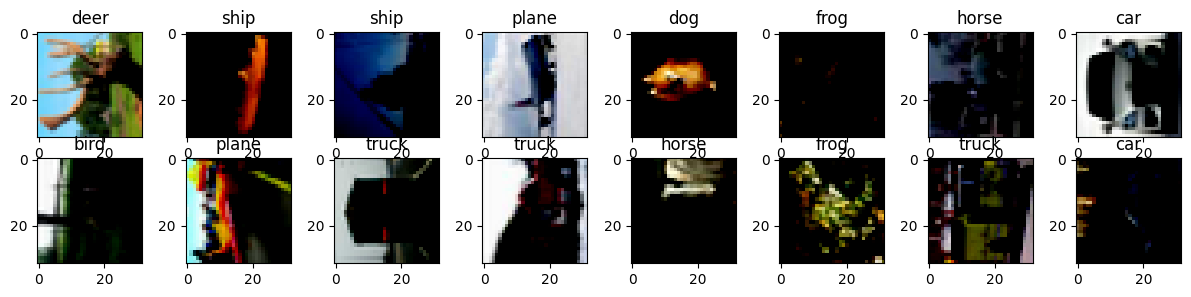

In [4]:
rows=2
cols=8
fig,axes=plt.subplots(nrows=rows,ncols=cols,figsize=(15,3))
for images,labels in tqdm(train_loader):
    images=images.numpy()
    labels=labels.numpy()
    for idx,img in enumerate(images):
        ax= axes[idx//cols,idx%cols]
        ax.imshow(img.T)
        label=labels[idx]
        ax.set_title(f"{classes[label]}")
    break

# Model

In [5]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNetwork,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=1,padding=0)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=1,padding=0)
        self.relu2=nn.ReLU()
        # self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        # self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=1,padding=0)
        self.flatten=nn.Flatten() # need to flatten CNN last layer to match fully connected layer
        self.linear1=nn.LazyLinear(64)
        self.linear2=nn.Linear(64,10)
    def forward(self,x):
        x=self.conv1(x)
        x=self.maxpool1(x)
        x=self.relu1(x)


        x=self.conv2(x)
        x=self.maxpool2(x)
        x=self.relu2(x)

        x=self.flatten(x)
        x=self.linear1(x)
        x=self.linear2(x)
        return x


In [6]:
def one_hot_encoder(label):
    # One-hot encode the labels
    one_hot_labels = torch.zeros((len(label), 10)) # new 10 dimension 
    one_hot_labels[torch.arange(len(label)), label] = 1 # set index to 1 if match to label index
    return one_hot_labels

In [16]:
epoches=20

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ConvolutionNetwork()
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
#summary(model, input_size=(3,32,32))
total_step=len(train_loader)
total_training={"loss":[],"acc":[]}
total_val={"loss":[],"acc":[]}
for epoch in range(epoches):

    running_loss=0.0
    total_train_size=0.0
    correct=0.0
    for i,(images,labels)in tqdm(enumerate(train_loader)):
        images=images.to(device)
        #print(images.size())
        labels=labels.to(device)
        ont_hot_labels=one_hot_encoder(labels)
        #print(labels)
        outputs=model(images)
        loss=criterion(outputs,labels)

        # calculate accuracy
        _ , predicted = outputs.max(1)


        total_train_size+=labels.size(0)
        correct+=predicted.eq(labels).sum().item()



        # recoder loss
        running_loss+= loss.item()
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{epoches}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    training_loss=running_loss/len(train_loader)
    training_acc=correct/total_train
    total_training["loss"].append(training_loss)
    total_training["acc"].append(training_acc)


    with torch.no_grad():
        running_loss=0.0
        total_val_size=0.0
        correct=0.0
        for i,(images,labels)in tqdm(enumerate(val_loader)):
            images=images.to(device)
            labels=labels.to(device)
            
            
            outputs=model(images)

            # calculate accuracy
            _ , predicted = outputs.max(1)


            total_val_size+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

            # calculate loss

            running_loss+= criterion(outputs,labels)

            
        val_loss=running_loss/len(val_loader)
        val_acc=correct/total_val_size
        total_val["loss"].append(val_loss)
        total_val["acc"].append(val_loss)

        print(f'Epoch [{epoch+1}/{epoches}] training_loss: {training_loss:.4f} training_accuracy: {training_acc} \
            \n   val_Loss: {val_loss:.4f} val_accuracy: {val_acc}')


print('Training finished.')

/home/nickson/anaconda3/envs/test/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
2500it [00:15, 159.13it/s]
625it [00:02, 224.11it/s]


TypeError: unsupported operand type(s) for /: 'float' and 'dict'